In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
from sympy.solvers import solve
from sympy import Symbol
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import pickle

In [210]:
N=10
K=100
T=1000
avg_rt_list = []
rt_list = []
avg_rte_list = []
rte_list=[]
boundary=1/2
shard_in_set = []
in_set = []
distance_list = []
trigger= 0
trigger_threshold = 0.001
beta=1
r=np.log(K)
l=1/2/K
queue_len = np.zeros((K,T))
S=min(N,K)
b=0.1
q = b/(1-2*b)
latency_stats = []
latency_queue = []
for k in range(K):
    latency_stats.append([])
    latency_queue.append([])
all_latency_stats = []

In [211]:
target_tp_list = np.zeros((K))
temp_sum=0.0
for i in range(K):
    temp_sum += 1.0/(int(i/5)+1)
    target_tp_list[i]=(1.0/(int(i/5)+1))
temp_norm = max(temp_sum*2/S,2)
target_tp_list = (target_tp_list/temp_norm)
if False:
    for i in range(K):
        target_tp_list[i]=1.0/2
    target_tp_list = (target_tp_list)*(S/K)    
if False:
    for i in range(4,K):
        target_tp_list[i] = 0.02
    for i in range(4):
        target_tp_list[i] = 0.5
queue_target_list = 100*0.8*(target_tp_list)

In [212]:
list0= []
temp = list0[1:]
#print(latency_queue[K-1])
print(sum(target_tp_list))
#print(target_tp_list)

5.0


In [213]:
def update_queue_len(inst_tp, t):
    remove = 100*inst_tp
    add = np.zeros((K))
    for k in range(K):
        add[k] = int(np.random.poisson(queue_target_list[k]))
        for i in range(int(add[k])):
            latency_queue[k].append(t)
        temp_removed = latency_queue[k][0:int(remove[k])]
        latency_queue[k] = latency_queue[k][int(remove[k]):]
        for time in temp_removed:
            latency_stats[k].append(t-time)
            all_latency_stats.append(t-time)
    diff = add - remove
    queue_len[:,t] = queue_len[:,t-1] + diff
    zero_vector = np.zeros((K))
    queue_len[:,t] = np.maximum(queue_len[:,t],zero_vector)
    return None

In [214]:
def generate_honest_strategy_constrained(avg_tp):
    inst_strategy = np.zeros(K)
    for k in range(K):
        if(avg_tp[k]<target_tp_list[k]):
            inst_strategy[k]=(target_tp_list[k]-avg_tp[k])
    if sum(inst_strategy)>0:
        arg_sorted_strategy = np.argsort(inst_strategy)
        for k in range(0,K-S):
            inst_strategy[arg_sorted_strategy[k]] = 0
        inst_strategy = inst_strategy/sum(inst_strategy)
        #start projection
        for k in range(K-S,K):
            if inst_strategy[arg_sorted_strategy[k]] < (q/K):
                inst_strategy[arg_sorted_strategy[k]] = (q/K)
        inst_strategy = inst_strategy/sum(inst_strategy)
        # added efficient projection (Not with 1/(1+2q))
    else:
        inst_strategy = inst_strategy + 1/K
    return inst_strategy

In [215]:
def check_shard_in_set(inst_tp):
    inst_shard_in_set = []
    inst_in_set=True
    for k in range(K):
        inst_shard_in_set.append(int(inst_tp[k]>=boundary))
        inst_in_set = inst_in_set and (inst_tp[k]>=boundary)
    return (inst_shard_in_set,inst_in_set)

In [216]:
def get_distance(avg_tp):
    d=0
    for k in range(K):
        if avg_tp[k]<boundary:
            d = d + (boundary - avg_tp[k])**2
    d = d**(1/2)
    return d

In [217]:
def generate_honest_strategy(avg_tp):
    inst_strategy = np.zeros(K)
    for k in range(K):
        if(avg_tp[k]<target_tp_list[k]):
            inst_strategy[k]=(target_tp_list[k]-avg_tp[k])
    if sum(inst_strategy)>0:
        arg_sorted_strategy = np.argsort(inst_strategy)
        for k in range(0,K-S):
            inst_strategy[arg_sorted_strategy[k]] = 0
        inst_strategy = inst_strategy/sum(inst_strategy)
    else:
        inst_strategy = inst_strategy + (1/max(N,K))
    return inst_strategy

In [218]:
def generate_honest_strategy_pure_blackwell(avg_tp):
    inst_strategy = np.zeros(K)
    for k in range(K):
        if(avg_tp[k]<target_tp_list[k]):
            inst_strategy[k]=(target_tp_list[k]-avg_tp[k])
    if sum(inst_strategy)>0:
        inst_strategy = inst_strategy/sum(inst_strategy)
    else:
        #inst_strategy = inst_strategy + (1/max(N,K))
        pass
    return inst_strategy

In [219]:
def generate_adv_strategy(avg_tp,honest_strategy):
    inst_strategy = np.zeros(K)
    for k in range(K):
        if(avg_tp[k]<target_tp_list[k]):
            inst_strategy[k]=(target_tp_list[k]-avg_tp[k])
    if sum(inst_strategy)>0:
        inst_strategy = inst_strategy/sum(inst_strategy)
    else:
        print("exception")
        inst_strategy[0]=1.0
    return inst_strategy

In [220]:
def generate_adv_strategy2(avg_tp,honest_strategy):
    attack_shard = np.argmin(honest_strategy)
    inst_strategy = np.zeros(K)
    inst_strategy[attack_shard]=1.0
    return inst_strategy

In [221]:
def generate_adv_strategy3(avg_tp,honest_strategy):
    N_min = int(np.sqrt(K))
    idx = np.argpartition(avg_tp,N_min)
    inst_strategy = np.zeros(K)
    for k in idx[:N_min]:
        inst_strategy[k] = 1.0/N_min
    return inst_strategy  

In [222]:
def generate_adv_strategy_plain(avg_tp,honest_strategy):
    inst_strategy = np.zeros(K)
    for k in range(K):
        inst_strategy[k] = 1.0/K
    return inst_strategy  

In [223]:
def generate_adv_strategy_latency(inst_tp,honest_strategy,time):
    sorted_id = np.argsort(np.array(inst_tp))
    mod = np.log(beta/l)/np.log(r)
    #print(mod)
    N_min = int(beta/(r**(time%mod)*l))+1
    #print(N_min)
    ind_beta = r**(time%mod)*l
    inst_strategy = np.zeros(K)
    for k in sorted_id[:N_min]:
        inst_strategy[k] = ind_beta
    return inst_strategy   

In [224]:
def get_inst_tp(honest_strategy,adv_strategy):
    inst_tp=np.zeros(K)
    for k in range(K):
        if honest_strategy[k]>0 and adv_strategy[k]>0:
            #inst_tp[k]= honest_strategy[k]/(honest_strategy[k]+adv_strategy[k])
            #hs = np.random.poisson(10000*honest_strategy[k])
            #ads = np.random.poisson(10000*adv_strategy[k])
            hs = honest_strategy[k]
            ads = adv_strategy[k]
            inst_tp[k]= hs/(hs + ads)
        elif honest_strategy[k]>0 and adv_strategy[k]<=0:
            inst_tp[k]=1.0
        else:
            inst_tp[k]=0.0
    return inst_tp

In [225]:
def get_inst_tp_estimate(honest_strategy, adv_strategy, ideal_honest_strategy):
    ideal_inst_tp=np.zeros(K)
    for k in range(K):
        if False:
            ideal_inst_tp[k] = ideal_honest_strategy[k]/(honest_strategy[k]+adv_strategy[k]+1)
        else:
            if ideal_honest_strategy[k]>0 and honest_strategy[k]+adv_strategy[k]>ideal_honest_strategy[k]:
                ideal_inst_tp[k] = ideal_honest_strategy[k]/(honest_strategy[k]+adv_strategy[k])
            elif ideal_honest_strategy[k]>0 and honest_strategy[k]+adv_strategy[k]<=ideal_honest_strategy[k]:
                ideal_inst_tp[k]=1.0
            else:
                ideal_inst_tp[k]=0.0
    return ideal_inst_tp


In [226]:
def get_actual_honest_strategy(ideal_honest_strategy):
    prob = np.array(ideal_honest_strategy)/np.sum(ideal_honest_strategy)
    shards = np.arange(K)
    actual_honest_strategy = np.zeros(K)
    for i in range(N):
        choice = np.random.choice(shards,p=prob)
        actual_honest_strategy[int(round(choice))] +=1
    actual_honest_strategy = actual_honest_strategy/N
    return actual_honest_strategy

In [227]:
origin_state = np.zeros(K)
#origin_state = origin_state + 1
#origin_state[0] = 1/2/K
#origin_state[K-1] = 1/2/K
#TEMP REMOVE ASAP
origin_state = origin_state + 1/2
#TEMP END

avg_rt_list.append(origin_state)
rt_list.append(origin_state)
#TODO: Add randomness here
avg_rte_list.append(origin_state)
rte_list.append(origin_state)
#END TODO
(inst_shard_in_set,inst_in_set) = check_shard_in_set(origin_state)
shard_in_set.append(np.array(inst_shard_in_set))
in_set.append(inst_in_set)
dist = get_distance(avg_rt_list[0])
distance_list.append(dist)

In [228]:
print(shard_in_set)
print(in_set)

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])]
[True]


In [229]:
for t in range(1,T):
    #ideal_honest_strategy = generate_honest_strategy_constrained(avg_rte_list[t-1])
    #ideal_honest_strategy = generate_honest_strategy(avg_rte_list[t-1])
    ideal_honest_strategy = generate_honest_strategy_pure_blackwell(avg_rte_list[t-1])
    honest_strategy = get_actual_honest_strategy(ideal_honest_strategy)
    #honest_strategy = ideal_honest_strategy
    adversarial_strategy = generate_adv_strategy_plain(avg_rt_list[t-1],honest_strategy)
    #adversarial_strategy = generate_adv_strategy_latency(rt_list[t-1],honest_strategy,t)
    inst_tp = get_inst_tp(honest_strategy,adversarial_strategy)
    update_queue_len(inst_tp,t)
    #inst_tp_estimate = get_inst_tp_estimate(honest_strategy,adversarial_strategy,ideal_honest_strategy)
    inst_tp_estimate = inst_tp
    rte_list.append(np.array(inst_tp_estimate))
    avg_rte_list.append((t/(t+1))*avg_rte_list[t-1]+(1/(t+1))*np.array(inst_tp_estimate))
    rt_list.append(np.array(inst_tp))
    avg_rt_list.append((t/(t+1))*avg_rt_list[t-1]+(1/(t+1))*np.array(inst_tp))
    (inst_shard_in_set,inst_in_set) = check_shard_in_set(np.array(inst_tp))
    shard_in_set.append(np.array(inst_shard_in_set))
    in_set.append(inst_in_set)
    dist = get_distance(avg_rt_list[t])
    distance_list.append(dist)
    if dist>trigger_threshold:
        trigger = max(trigger,t)

/Users/ranvirrana/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/ranvirrana/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


In [230]:
min_rt_list = []
for t in range(T):
    min_rt_list.append(np.min(avg_rt_list[t]))
max_latency_list = []
for t in range(T):
    max_latency_list.append(np.max(queue_len[:,t]))

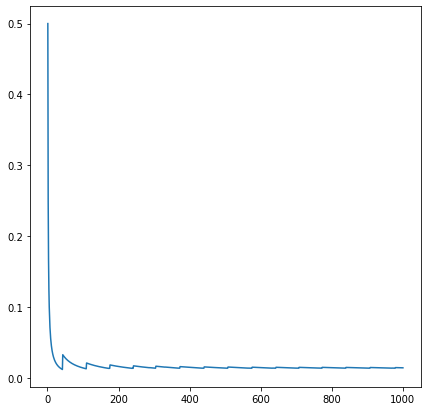

In [231]:
plt.figure(figsize=(7,7))
x_axis = np.arange(1,T+1,1)
y_axis_1 = np.array(min_rt_list)
plt.plot(x_axis, y_axis_1)
#plt.xlabel("Time")
#plt.ylabel("Normalized Throughput")
#plt.title("Worst case shard throughput")
plt.show()
#plt.savefig("/Users/ranvirrana/Dropbox/Sharding_Talk/simulation_plots/latency_bound_adv/worst_shard_tp.png")
#plt.savefig("/Users/ranvirrana/Dropbox/ccs2020/latency_bound_adv/worst_shard_tp6.pdf")

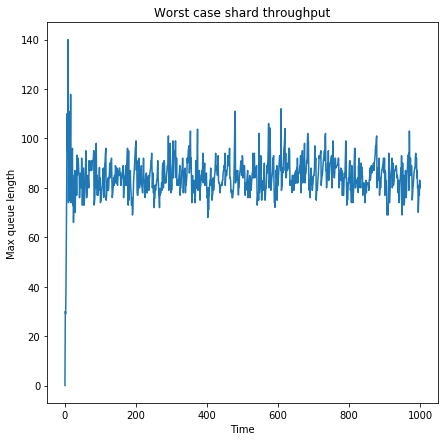

In [232]:
plt.figure(figsize=(7,7))
x_axis = np.arange(1,T+1,1)
y_axis_1 = np.array(max_latency_list)
plt.plot(x_axis, y_axis_1)
plt.xlabel("Time")
plt.ylabel("Max queue length")
plt.title("Worst case shard throughput")
plt.show()
#plt.savefig("/Users/ranvirrana/Dropbox/ccs2020/latency_bound_adv/queue_len2.pdf")

In [233]:
latency_mean = []
for k in range(K):
    temp_mean = np.mean(np.array(latency_stats[k]))
    latency_mean.append(temp_mean)
net_latency_mean = np.mean(np.array(all_latency_stats))
print(net_latency_mean)

8.73401619074


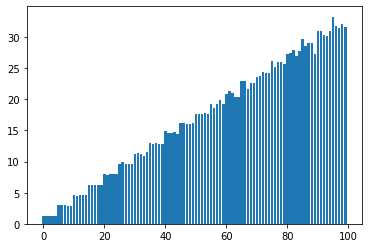

In [234]:
# Latency histogram
plt.close()
plt.bar(np.arange(K), latency_mean, bottom=0)
#plt.xlabel("Shards")
#plt.ylabel("Mean latency")
plt.show()
#plt.savefig("/Users/ranvirrana/Dropbox/ccs2020/latency_bound_adv/latency6.pdf")

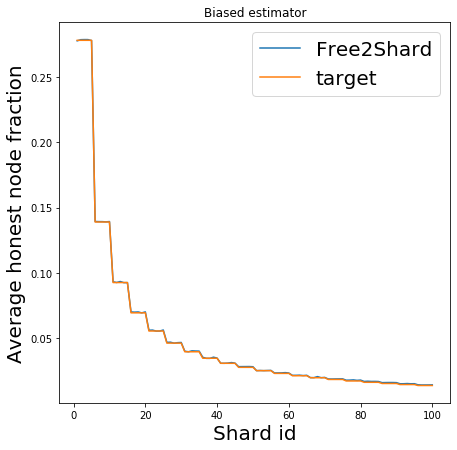

In [235]:
# Latency histogram
plt.close()
plt.figure(figsize=(7,7))
x_axis = np.arange(1,K+1,1)
y_axis_1 = np.array(avg_rt_list[T-1])
y_axis_2 = np.array(target_tp_list)
plt.plot(x_axis, y_axis_1)
plt.plot(x_axis, y_axis_2)
plt.legend(['Free2Shard','target'],fontsize=20)
plt.xlabel("Shard id",fontsize=20)
plt.ylabel("Average honest node fraction",fontsize=20)
plt.title("Biased estimator")
#plt.ylim(0.25*S/K, 1.5*S/K)
#plt.xlabel("Shards")
#plt.ylabel("Normalized throughput")
plt.show()
#plt.savefig("/Users/ranvirrana/Dropbox/ccs2020/intermediate_experiments/target_tp1_unbiased.png")

In [53]:
avg_rt_arg_sort = np.argsort(np.array(avg_rt_list[T-1]))
min_shard = avg_rt_arg_sort[0]
min2_shard = avg_rt_arg_sort[1]


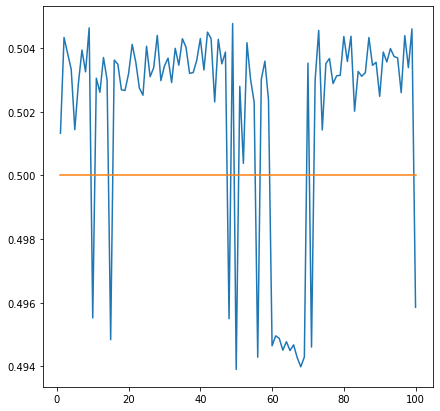

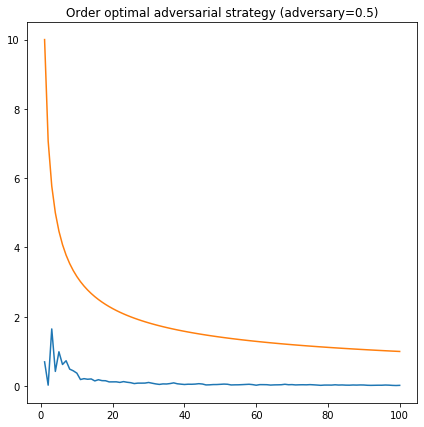

In [60]:
plt.figure(figsize=(7,7))
x_axis = np.arange(1,T+1,1)
y_axis_1 = np.array(distance_list)
upper_bound = []
for t in range(T):
    upper_bound.append((K/(t+1))**(1/2))
y_axis_2 = np.array(upper_bound)
#plt.semilogx(x_axis, avg_tp)
plt.plot(x_axis, y_axis_1)
plt.plot(x_axis, y_axis_2)
#plt.xlabel("log(K)/loglog(K)")
#plt.ylabel("1/TP")
#plt.legend(["r=logK"])
plt.title("Order optimal adversarial strategy (adversary=0.5)")
plt.show()

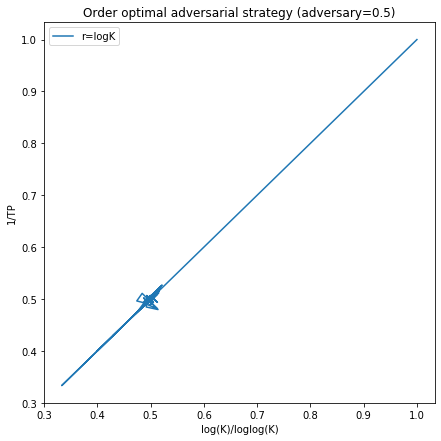

In [61]:
plt.figure(figsize=(7,7))
x_axis = np.array(avg_rt_list)[:,1]
y_axis = np.array(avg_rt_list)[:,6]
#plt.semilogx(x_axis, avg_tp)
plt.plot(x_axis, y_axis)
plt.xlabel("log(K)/loglog(K)")
plt.ylabel("1/TP")
plt.legend(["r=logK"])
plt.title("Order optimal adversarial strategy (adversary=0.5)")
plt.show()

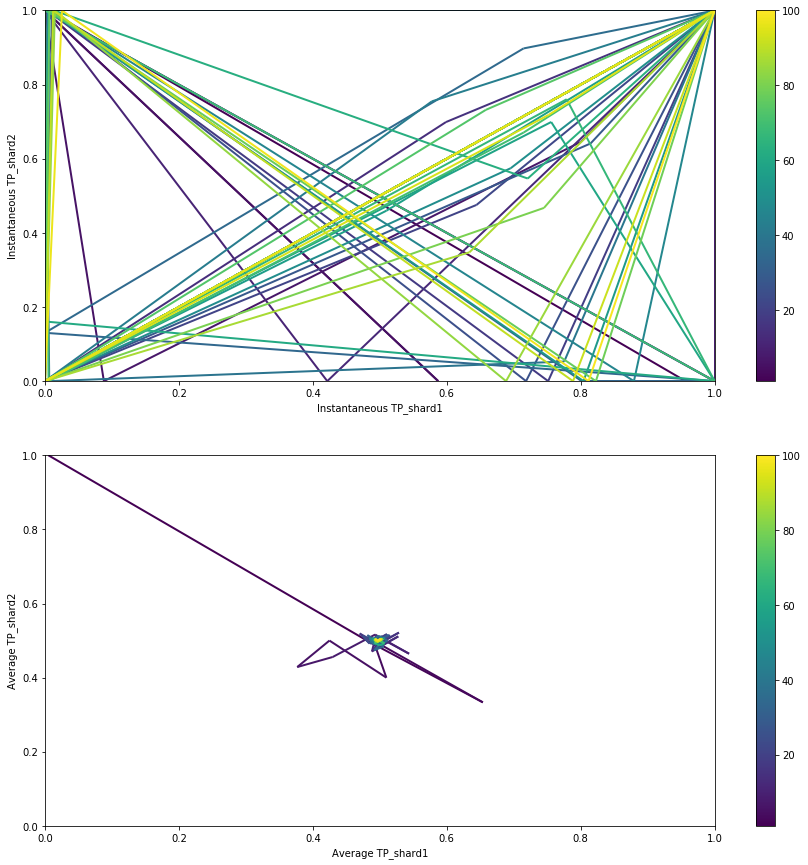

In [78]:
shard_1=0
shard_2=1
x = np.array(rt_list)[:,shard_1]
y = np.array(rt_list)[:,shard_2]
x_avg = np.array(avg_rt_list)[:,shard_1]
y_avg = np.array(avg_rt_list)[:,shard_2]
dydx = np.arange(1,T+1,1)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, figsize=(15,15))
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])
axs[0].set_xlabel("Instantaneous TP_shard1")
axs[0].set_ylabel("Instantaneous TP_shard2")

points_avg = np.array([x_avg, y_avg]).T.reshape(-1, 1, 2)
segments_avg = np.concatenate([points_avg[:-1], points_avg[1:]], axis=1)

lc_avg = LineCollection(segments_avg, cmap='viridis', norm=norm)
lc_avg.set_array(dydx)
lc_avg.set_linewidth(2)
line_avg = axs[1].add_collection(lc_avg)
fig.colorbar(line_avg, ax=axs[1])
axs[1].set_xlabel("Average TP_shard1")
axs[1].set_ylabel("Average TP_shard2")

plt.show()
#plt.savefig("/Users/ranvirrana/Dropbox/Sharding_Talk/simulation_plots/rootK_min_adversary/random_shards_evo.png")

49
67


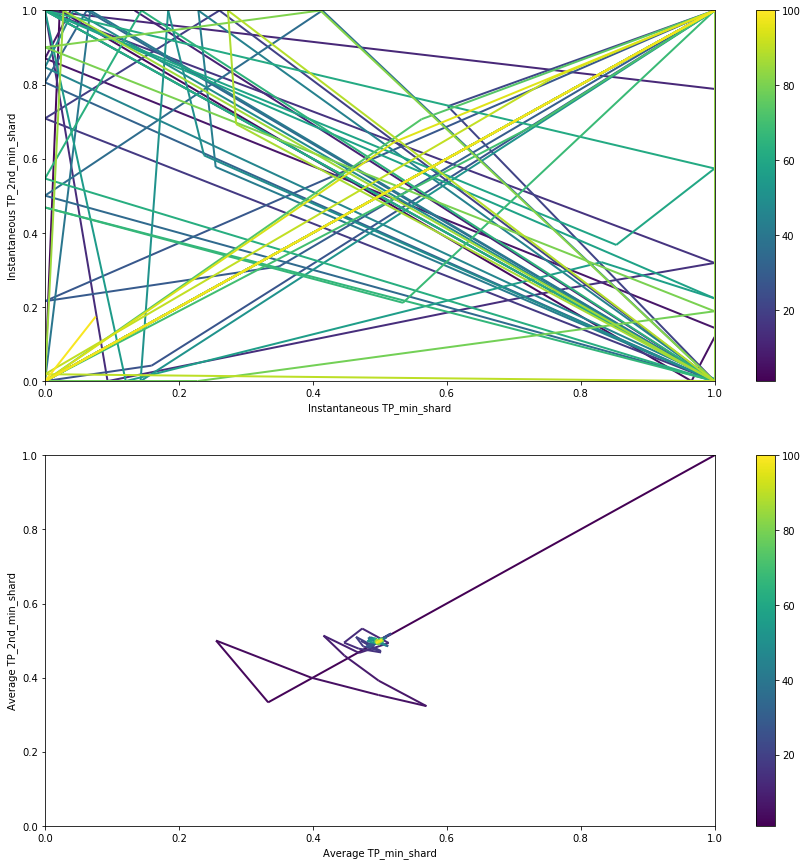

In [64]:
print(min_shard)
print(min2_shard)
shard_1=min_shard
shard_2=min2_shard
x = np.array(rt_list)[:,shard_1]
y = np.array(rt_list)[:,shard_2]
x_avg = np.array(avg_rt_list)[:,shard_1]
y_avg = np.array(avg_rt_list)[:,shard_2]
dydx = np.arange(1,T+1,1)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, figsize=(15,15))
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])
axs[0].set_xlabel("Instantaneous TP_min_shard")
axs[0].set_ylabel("Instantaneous TP_2nd_min_shard")

points_avg = np.array([x_avg, y_avg]).T.reshape(-1, 1, 2)
segments_avg = np.concatenate([points_avg[:-1], points_avg[1:]], axis=1)

lc_avg = LineCollection(segments_avg, cmap='viridis', norm=norm)
lc_avg.set_array(dydx)
lc_avg.set_linewidth(2)
line_avg = axs[1].add_collection(lc_avg)
fig.colorbar(line_avg, ax=axs[1])
axs[1].set_xlabel("Average TP_min_shard")
axs[1].set_ylabel("Average TP_2nd_min_shard")

plt.show()
#plt.savefig("/Users/ranvirrana/Dropbox/Sharding_Talk/simulation_plots/rootK_min_adversary/min_shards_evo.png")

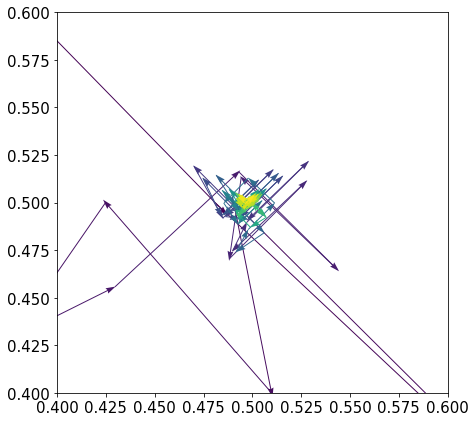

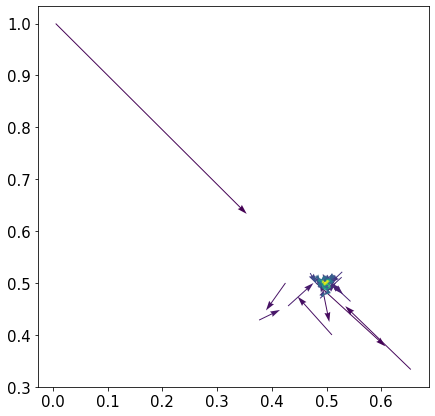

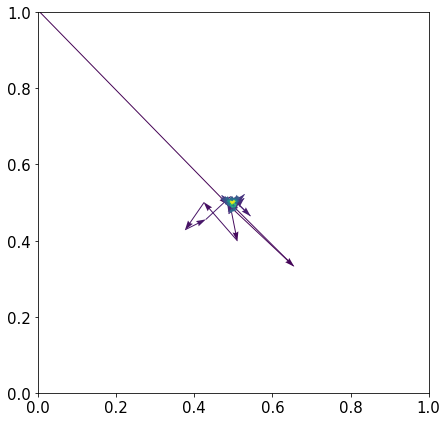

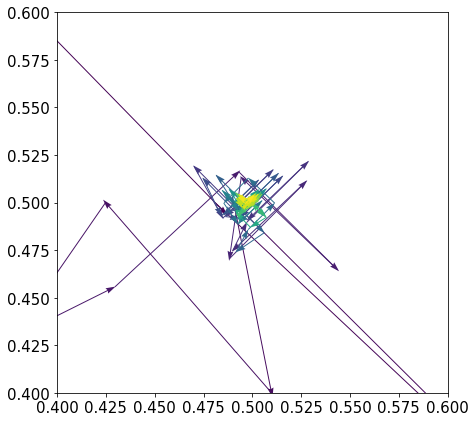

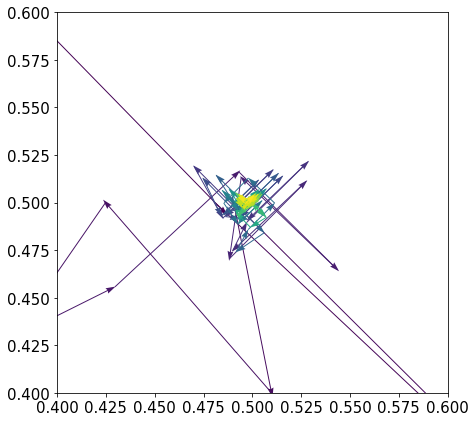

In [83]:
#shard_1=min_shard
#shard_2=min2_shard
shard_1=0
shard_2=1
x_avg = np.array(avg_rt_list)[:,shard_1]
y_avg = np.array(avg_rt_list)[:,shard_2]
U = np.zeros(T)
V = np.zeros(T)
time = np.arange(1,T+1,1)
widths = np.zeros(T)
for t in range(T-1):
    U[t] = (x_avg[t+1] - x_avg[t])
    V[t] = (y_avg[t+1] - y_avg[t])
    
fig1, ax1 = plt.subplots(figsize=(7,7))
#ax1.set_title('Arrows scale with plot width, not view')
Q = ax1.quiver(x_avg, y_avg, U, V, time, cmap='viridis', angles='xy', width=0.0025, scale=0.2, headwidth=6, headlength=10, headaxislength=9)
#qk = ax1.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
#                   coordinates='figure')
#print(U)
#print(x_avg)
#print(V)
plt.xlim(0.4,0.6)
plt.ylim(0.4,0.6)
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#ax1.set_xlabel("Instantaneous TP min shard", fontsize=15)
#ax1.set_ylabel("Instantaneous TP 2nd shard", fontsize=15)
'''
norm = plt.Normalize(time.min(), time.max())
lc = LineCollection(, cmap='viridis', norm=norm)
lc.set_array(time)
#lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig1.colorbar(line, ax=ax1)
'''
plt.show()
#plt.savefig("/Users/ranvirrana/Dropbox/Sharding_Talk/simulation_plots/rootK_min_adversary/min_shards_evo_vector_zoom.png")
#plt.savefig("/Users/ranvirrana/Dropbox/ccs2020/latency_bound_adv/avg_zoom6.pdf")

In [74]:
stored_vars = {}
stored_vars['avg_rt_list'] = avg_rt_list
stored_vars['rt_list'] = rt_list
stored_vars['distance_list'] = distance_list
stored_vars['latency_stats'] = latency_stats
stored_vars['all_latency_stats'] = all_latency_stats
stored_vars['latency_queue'] = latency_queue
stored_vars['target_tp_list'] = target_tp_list
stored_vars['min_rt_list'] = min_rt_list
stored_vars['latency_mean'] = latency_mean
stored_vars['net_latency_mean'] = net_latency_mean
stored_vars['queue_len'] = queue_len

with open('/Users/ranvirrana/Dropbox/ccs2020/latency_bound_adv/dict6.pickle', 'wb') as handle:
    pickle.dump(stored_vars, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [49]:
in_set_latency=0
shard_in_set_latency=np.zeros(K)
g=1
temp_in_set_latency=0
temp_shard_in_set_latency=np.zeros(K)

for t in range(T):
    if not in_set[t]:
        temp_in_set_latency += 1
        in_set_latency=max(in_set_latency,temp_in_set_latency)
    else:
        in_set_latency=max(in_set_latency,temp_in_set_latency)
        temp_in_set_latency=0
    #Now analyze g-good latency of each shard
    for k in range(K):
        if (rt_list[t][k]<g):
            temp_shard_in_set_latency[k] += 1
            shard_in_set_latency[k] = max(shard_in_set_latency[k],temp_shard_in_set_latency[k])
        else:
            shard_in_set_latency[k] = max(shard_in_set_latency[k],temp_shard_in_set_latency[k])
            temp_shard_in_set_latency[k]=0

In [59]:
print(in_set_latency)
print(max(shard_in_set_latency))
print(trigger)
#print(distance_list)

100
5.0
99


In [123]:
m_list = [1,2,3,4,5,10,20,50]
min_tp_list = []
rt_list_np = np.array(rt_list)
for m in m_list:
    min_tp=1
    for t in range(T-m+1):
        for k in range(K):
            min_tp = min(min_tp,np.mean(rt_list_np[t:t+m]))
    min_tp_list.append(min_tp)


KeyboardInterrupt: 

In [ ]:
print(min_tp_list)

In [ ]:
plt.figure(figsize=(7,7))
x_axis = m_list
y_axis = min_tp_list
#plt.semilogx(x_axis, avg_tp)
plt.plot(x_axis, y_axis)
plt.xlabel("window length")
plt.ylabel("min window tp")
plt.legend(["window tp"])
plt.title("Window TP")
plt.show()